Exploration of the KS Differential Entropy. Explore custom implementation of entropy and it's gradients in terms of unconstrained parameters. Not used in final paper implementation.

# Digamma and Trigamma Function

Digamma $\Psi^{(0)}$, Trigamma $\Psi^{(1)}$

$\Psi^{(1)}(x+1) = \frac{d}{dx} \Psi^{(0)}(x+1)$

Euler-Mascheroni constant $\gamma = \Psi^{(0)}(1)$

# Kumaraswamy Differential Entropy

IN MODEL TRAINING THERE SEEMS TO BE SOME ISSUE WITH OUR IMPLEMENTATION....USING PYTORCH KS ENTROPY FUNCTION FOR NOW

$H(a, b) = (1-\frac{1}{b}) + (1-\frac{1}{a}) \cdot ( \Psi^{(0)}(b + 1) + \gamma ) - \ln(a) - \ln(b)$

$ \nabla_a H(a, b) = \frac{1}{a^2} \cdot (\Psi^{(0)}(b + 1) + \gamma) - \frac{1}{a}$

$ \nabla_b H(a, b) = \frac{1}{b^2} + (1 - \frac{1}{a}) \cdot \Psi^{(1)}(b + 1) - \frac{1}{b}$


## In terms of $log_a$ and $log_b$

$ a = \exp(\log a) $, $ b = \exp(\log b) $, $ a_{inv} = \exp(-\log a) $, $ b_{inv} = \exp(-\log b) $

$ \nabla_{\log_a} H(\log a, \log b) = a_{inv} \cdot (\Psi^{(0)}(b + 1) + \gamma) - 1$

$ \nabla_{\log_b} H(\log a, \log b) = b_{inv} + b \cdot (1 - a_{inv}) \cdot \Psi^{(1)}(b + 1) - 1$

In [213]:
import torch
from torch.autograd import grad, gradcheck

import numpy as np
from torch.special import digamma, polygamma

# import euler-mascheroni constant
from kumaraswamy import euler_constant, log1mexp, kumaraswamy_stable_entropy

from torch.distributions import Kumaraswamy as torch_Kumaraswamy

import matplotlib.pyplot as plt
from config import FIGURES_DIR

log, log2, exp2, exp, log10 = torch.log, torch.log2, torch.exp2, torch.exp, torch.log10

In [ ]:
x = torch.linspace(-100, 100, 100000, dtype=torch.float64)
y = digamma(exp(x) + 1)
z = polygamma(1, exp(x) + 1)


### Inspecting Digamma and Trigamma Function

In [ ]:
# make two subplots: the first with normal y scale, the second with log y scale

fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(x, y, label="digamma(x+1)")
axs[0].plot(x, z, label="trigamma(x+1)")
#axs[0].plot(x, log(z), label="log trigamma(x+1)")
axs[0].set_xlabel("log x")
axs[0].set_ylabel("y")
axs[0].set_ylim(-1, 10)

axs[1].plot(x, y, label="digamma(x+1)")
axs[1].plot(x, z, label="trigamma(x+1)")
axs[1].set_xlabel("log x")
axs[1].set_yscale("log")
axs[1].set_ylabel("log y")

axs[0].legend()
plt.tight_layout()
plt.show()


## Kumaraswamy Differential Entropy

In [214]:
class KumaraswamyStableEntropy(torch.autograd.Function):

    @staticmethod
    def forward(ctx, log_a: torch.Tensor, log_b: torch.Tensor):
        a_inv, b_inv, b = exp(-log_a), exp(-log_b), exp(log_b)
        digamma_euler = digamma(b + 1) + euler_constant

        ctx.save_for_backward(b, a_inv, b_inv, digamma_euler)
        return (1 - b_inv) + (1 - a_inv) * digamma_euler - log_a - log_b

    @staticmethod
    def backward(ctx, grad_output):
        b, a_inv, b_inv, digamma_euler = ctx.saved_tensors

        grad_log_a = grad_log_b = None

        if ctx.needs_input_grad[0]:
            nabla_log_a = a_inv * digamma_euler - 1.0
            grad_log_a = grad_output * nabla_log_a
        if ctx.needs_input_grad[1]:
            # TODO: (1-a_inv) may be unstable...Can test with ~ log1mexp( log_a )
            #stable_1ma_inv = (1-a_inv).sign() * log1mexp(log_a.abs())# unsure if correct
            nabla_log_b = b_inv + b * (1-a_inv) * polygamma(1, b + 1.0) - 1.0
            grad_log_b = grad_output * nabla_log_b
        
        return grad_log_a, grad_log_b 

# Generate input ranges
log_a_vals = torch.linspace(-100, 16, steps=50, dtype=torch.double, requires_grad=True)
log_b_vals = torch.linspace(-16, 100, steps=50, dtype=torch.double, requires_grad=True)

# *** empirically find stable in log_a \in [-100, 16], log_b \in [-16, 100] ***

# Prepare input pairs
input_pairs = [(log_a, log_b) for log_a in log_a_vals for log_b in log_b_vals]

# Perform gradcheck for each pair
for log_a, log_b in input_pairs:
    log_a, log_b = log_a.clone().detach().requires_grad_(True), log_b.clone().detach().requires_grad_(True)
    try: 
        is_correct = gradcheck(KumaraswamyStableEntropy.apply, (log_a, log_b), eps=1e-6, atol=1e-4)
    except Exception as e:
        print(f"FAILURE {log_a.item()} {log_b.item()} {e}")

FAILURE -31.346938775510203 -16.0 Jacobian mismatch for output 0 with respect to input 1,
numerical:tensor([[1280248.8692]], dtype=torch.float64)
analytical:tensor([[1278657.0426]], dtype=torch.float64)

FAILURE -14.775510204081632 -16.0 Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[-0.4983]], dtype=torch.float64)
analytical:tensor([[-0.4992]], dtype=torch.float64)



### Compare to torch implementation

In [220]:
# Generate input ranges
log_a_vals = torch.linspace(-10, 10, steps=5, dtype=torch.double, requires_grad=True)
log_b_vals = torch.linspace(-10, 10, steps=12, dtype=torch.double, requires_grad=True)

# *** empirically find stable in log_a \in [-100, 16], log_b \in [-16, 100] ***

# Prepare input pairs
input_pairs = [(log_a, log_b) for log_a in log_a_vals for log_b in log_b_vals]

# Perform gradcheck for each pair
for log_a, log_b in input_pairs:
    # custom 
    log_a_custom, log_b_custom = log_a.clone().detach().requires_grad_(True), log_b.clone().detach().requires_grad_(True)
    
    # torch
    log_a_torch, log_b_torch = log_a.clone().detach().requires_grad_(True), log_b.clone().detach().requires_grad_(True)
    
    entropy_custom = KumaraswamyStableEntropy.apply(log_a_custom, log_b_custom)
    entropy_torch = torch_Kumaraswamy(log_a_torch.exp(), log_b_torch.exp()).entropy()

    # compare values
    try:
        assert torch.allclose(entropy_custom, entropy_torch, atol=1e-4)
    except Exception as e:
        print(f"FAILURE {log_a.item():.2f} {log_b.item():.2f} {e}: {entropy_custom.item():.5f} {entropy_torch.item():.5f}")
    
    # compare gradients
    try:
        entropy_custom.backward()
        entropy_torch.backward()
        assert torch.allclose(log_a_custom.grad, log_a_torch.grad, atol=1e-4)
        assert torch.allclose(log_b_custom.grad, log_b_torch.grad, atol=1e-4)
    except Exception as e:
        print(f"FAILURE {log_a.item():.2f} {log_b.item():.2f} {e}: log_a_grad: custom {log_a_custom.grad.item():.5f} torch {log_a_torch.grad.item():.5f} || log_b_grad: custom {log_b_custom.grad.item():.5f} torch {log_b_torch.grad.item():.5f}")

FAILURE -10.00 -10.00 : log_a_grad: custom 0.64503 torch 0.64488 || log_b_grad: custom 22023.82104 torch 22023.82104


In [159]:
#min_p, max_p = -15, 15
num_points = 2000
levels = 200

In [207]:
# Check and print non-finite values
def print_non_finite(log_A, log_B, array, name):
    non_finite_mask = ~np.isfinite(array)
    non_finite_indices = np.argwhere(non_finite_mask)
    print(f"Non-finite values in {name}:")
    for idx in non_finite_indices:
        i, j = idx
        print(f"\tlog_a: {log_A[i, j]:.2f}, log_b: {log_B[i, j]:.2f}, value: {array[i, j]}")

In [197]:
def plot_entropy_and_grads(log_A, log_B, H, H_nabla_log_a, H_nabla_log_b, title="", vmin=-5, vmax=10, print_ranges=False):
    fig, axes = plt.subplots(1,3, figsize=(18, 6), constrained_layout=True)

    fig.suptitle(title)

    # Calculate the log10 of the values
    log_H = np.log10(-H + 1e-10)
    log_H_nabla_log_a = np.log10(np.abs(H_nabla_log_a) + 1e-16)
    log_H_nabla_log_b = np.log10(np.abs(H_nabla_log_b) + 1e-16)

    # Replace non-finite values with a large negative number for log scales
    posinf = 20
    neginf = -20
    log_H = np.nan_to_num(log_H, nan=-np.inf, posinf=posinf, neginf=neginf)
    log_H_nabla_log_a = np.nan_to_num(log_H_nabla_log_a, nan=-np.inf, posinf=posinf, neginf=neginf)
    log_H_nabla_log_b = np.nan_to_num(log_H_nabla_log_b, nan=-np.inf, posinf=posinf, neginf=neginf)

    # Print the range of the data
    if print_ranges:
        print("Range of Data after finite replacement")
        print(f"\tRange of log_H: {log_H.min()} to {log_H.max()}")
        print(f"\tRange of log_H_nabla_log_a: {log_H_nabla_log_a.min()} to {log_H_nabla_log_a.max()}")
        print(f"\tRange of log_H_nabla_log_b: {log_H_nabla_log_b.min()} to {log_H_nabla_log_b.max()}")

    # clip the values to the range of the colorbar
    log_H = np.clip(log_H, vmin, vmax)
    log_H_nabla_log_a = np.clip(log_H_nabla_log_a, vmin, vmax)
    log_H_nabla_log_b = np.clip(log_H_nabla_log_b, vmin, vmax)

    # print the range of the data
    if print_ranges:
        print("Clipped Range of Data after clipping")
        print(f"\tRange of log_H: {log_H.min():.2f} to {log_H.max():.2f}")
        print(f"\tRange of log_H_nabla_log_a: {log_H_nabla_log_a.min():.2f} to {log_H_nabla_log_a.max():.2f}")
        print(f"\tRange of log_H_nabla_log_b: {log_H_nabla_log_b.min():.2f} to {log_H_nabla_log_b.max():.2f}")

    # Create the levels for contour
    levels = np.linspace(vmin, vmax, 200)
    cmap = 'viridis'
    
    # Plot the entropy H
    contour0 = axes[0].contourf(log_A, log_B, log_H, levels=levels, cmap=cmap)
    axes[0].set_title(r'Kumaraswamy Entropy: $\log_{10} -H$')

    # Plot the gradient w.r.t. log a
    contour1 = axes[1].contourf(log_A, log_B, log_H_nabla_log_a, levels=levels, cmap=cmap)
    axes[1].set_title(r'$\log_{10} | \nabla_{log a} H |$')

    # Plot the gradient w.r.t. log b
    contour2 = axes[2].contourf(log_A, log_B, log_H_nabla_log_b, levels=levels, cmap=cmap)
    axes[2].set_title(r'$\log_{10} | \nabla_{log b} H |$')

    for ax in axes:
        ax.set_xlabel('log a')
        ax.set_ylabel('log b')
        ax.grid(True)
        ax.axvline(0, color='black', lw=2)
        ax.axhline(0, color='black', lw=2)

    # Create a single colorbar for all plots
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=axes, orientation='vertical', fraction=0.02, pad=0.04, extend='both')
    cbar.set_label('Logarithmic Scale')

    plt.show()

    """ 
    # Plot the entropy H
    print(f"Maximum value of log10 - H: {np.max(np.log10(-H + 1e-10))}")
    contour0 = axes[0].contourf(log_A, log_B, np.log10(-H + 1e-10), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour0, ax=axes[0], extend='both')
    axes[0].set_title(r'Kumaraswamy Entropy: $\log_{10} -H$')

    # Plot the gradient w.r.t. log a
    contour1 = axes[1].contourf(log_A, log_B, np.log10(np.abs(H_nabla_log_a) + 1e-16), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour1, ax=axes[1], extend='both')
    axes[1].set_title(r'$\log_{10} | \nabla_{log a} H |$')

    # Plot the gradient w.r.t. log b
    contour2 = axes[2].contourf(log_A, log_B, np.log10(np.abs(H_nabla_log_b) + 1e-16), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour2, ax=axes[2], extend='both')
    axes[2].set_title(r'$\log_{10} | \nabla_{log b} H |$')

    for i in [0, 1, 2]:
        axes[i].set_xlabel('log a')
        axes[i].set_ylabel('log b')

        # set grid at all ticks
        axes[i].grid(True)

        # plot vertical and horizontal lines at 0
        axes[i].axvline(0, color='black', lw=2)
        axes[i].axhline(0, color='black', lw=2)


    plt.show()
    """

### Define range of $\log a$ and $\log b$ to inspect

In [201]:
## U shaped
# as log_a gets smaller, the approximation of a bernoulli gets better.
# below log_b = -7, the bernoulli approximates \delta(1) for large interval of log_a
#log_a_min, log_a_max = -75, 7
#log_b_min, log_b_max = -15, 13

# Bell shaped
log_a_min, log_a_max = -10, 7.5
log_b_min, log_b_max = -7.5, 50

### Plot Custom Implementation

In [202]:
log_a_vals = torch.linspace(log_a_min, log_a_max, num_points, requires_grad=True)
log_b_vals = torch.linspace(log_b_min, log_b_max, num_points, requires_grad=True)

log_A, log_B = torch.meshgrid(log_a_vals, log_b_vals, indexing='ij')

H = KumaraswamyStableEntropy.apply(log_A, log_B)

# Compute the gradient w.r.t. a and b using autograd
H_nabla_log_a = grad(H, log_A, torch.ones_like(H), create_graph=True)[0]
H_nabla_log_b = grad(H, log_B, torch.ones_like(H), create_graph=True)[0]

# Convert to numpy for plotting
log_A, log_B = log_A.detach().numpy(), log_B.detach().numpy()
H = H.detach().numpy()
H_nabla_log_a = H_nabla_log_a.detach().numpy()
H_nabla_log_b = H_nabla_log_b.detach().numpy()

In [210]:
custom = {'H': H, 'H_nabla_log_a': H_nabla_log_a, 'H_nabla_log_b': H_nabla_log_b}

In [203]:
print_non_finite(log_A, log_B, H, "H")
print_non_finite(log_A, log_B, H_nabla_log_a, "H_nabla_log_a")
print_non_finite(log_A, log_B, H_nabla_log_b, "H_nabla_log_b")

Non-finite values in H:
Non-finite values in H_nabla_log_a:
Non-finite values in H_nabla_log_b:


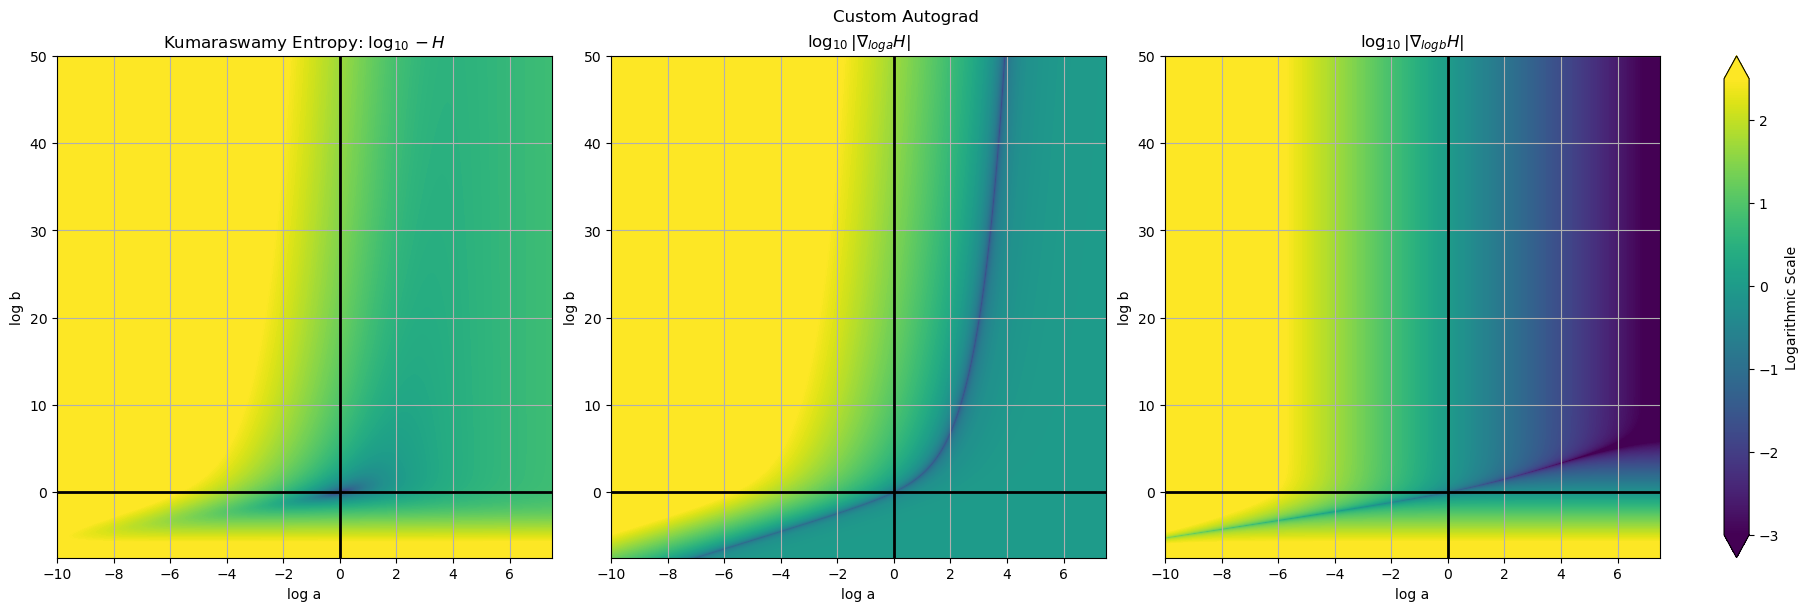

In [204]:
plot_entropy_and_grads(log_A, log_B, H, H_nabla_log_a, H_nabla_log_b, title="Custom Autograd",
                       vmin=-3, vmax=2.5)

### Plot Pytorch Implementation

In [208]:
log_a_vals = torch.linspace(log_a_min, log_a_max, num_points, requires_grad=True)
log_b_vals = torch.linspace(log_b_min, log_b_max, num_points, requires_grad=True)
log_A, log_B = torch.meshgrid(log_a_vals, log_b_vals, indexing='ij')
A, B = exp(log_A), exp(log_B)

H = torch.distributions.Kumaraswamy(A, B).entropy()

# Compute the gradient w.r.t. a and b using autograd
H_nabla_log_a = grad(H, log_A, torch.ones_like(H), create_graph=True)[0]
H_nabla_log_b = grad(H, log_B, torch.ones_like(H), create_graph=True)[0]

# Convert to numpy for plotting
log_A, log_B = log_A.detach().numpy(), log_B.detach().numpy()
H = H.detach().numpy()
H_nabla_log_a = H_nabla_log_a.detach().numpy()
H_nabla_log_b = H_nabla_log_b.detach().numpy()

print_non_finite(log_A, log_B, H, "H")
print_non_finite(log_A, log_B, H_nabla_log_a, "H_nabla_log_a")
print_non_finite(log_A, log_B, H_nabla_log_b, "H_nabla_log_b")

Non-finite values in H:
Non-finite values in H_nabla_log_a:
Non-finite values in H_nabla_log_b:


In [211]:
torch_vals = {'H': H, 'H_nabla_log_a': H_nabla_log_a, 'H_nabla_log_b': H_nabla_log_b}

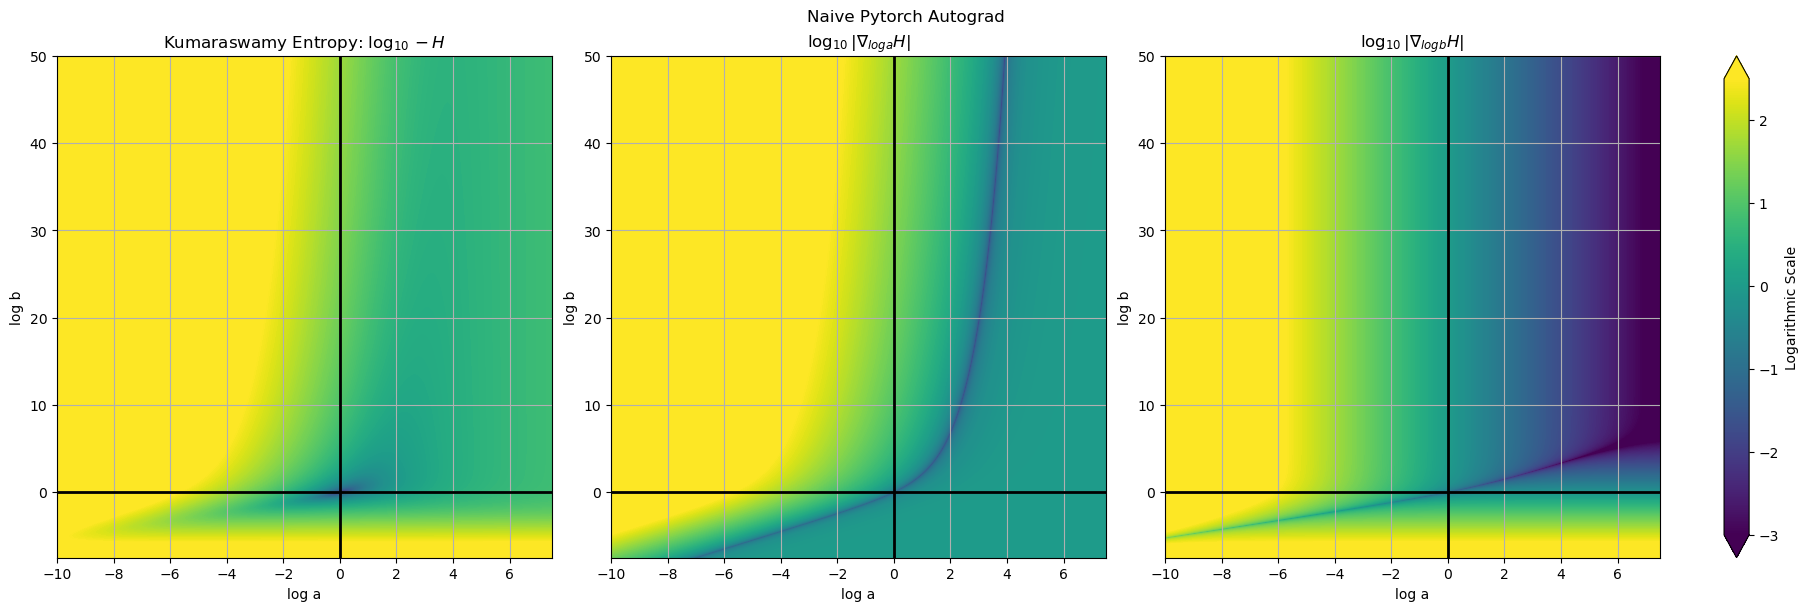

In [209]:
plot_entropy_and_grads(log_A, log_B, H, H_nabla_log_a, H_nabla_log_b, title="Naive Pytorch Autograd",
                       vmin=-3, vmax=2.5)

In [212]:
# compare custom and torch_vals
for key in custom:
    print(f"Comparing {key}")
    print(f"\tMax difference: {np.max(np.abs(custom[key] - torch_vals[key]))}")

Comparing H
	Max difference: 0.0
Comparing H_nabla_log_a
	Max difference: 0.0
Comparing H_nabla_log_b
	Max difference: 0.0


# OLD

In [ ]:
# Plotting
width = 0.35

# two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
# sampling
rects1 = ax1.bar(distribution_names, sample_means, width, label='Sampling', yerr=sample_stds, capsize=5)
ax1.set_ylabel('Time (s)')
#ax1.set_title('Time for Sampling')
ax1.set_xticks(distribution_names)
ax1.set_xticklabels(distribution_names)
ax1.legend()

# gradient computation
rects2 = ax2.bar(distribution_names, 1e3 * np.array(grad_means), width, label='Gradients', yerr=1e3 * np.array(grad_stds), capsize=5, color='orange')
#ax2.set_xlabel('Distributions')
ax2.set_ylabel('Time (1e-3 s)')
#ax2.set_title('Time for Gradients')
ax2.set_xticks(distribution_names)
ax2.set_xticklabels(distribution_names, rotation=25)
ax2.legend()
# set yticks to [0, 1, 2]
ax2.set_yticks([0, 0.5, 1, 1.5, 2.0, 2.5])


# Save the figure
plt.savefig(FIGURES_DIR + 'sampling_gradient_timing.png', bbox_inches='tight', pad_inches=0.01, dpi=200)
plt.show()

In [ ]:
min_p, max_p = -100, 100
num_points = 5000
levels = 200

In [ ]:
# Create a mesh grid for a and b values
a_vals = torch.logspace(min_p, max_p, num_points, base=2.0)
b_vals = torch.logspace(min_p, max_p, num_points, base=2.0)
A, B = torch.meshgrid(a_vals, b_vals, indexing='ij')

# Compute the entropy and its gradients
H = kumaraswamy_entropy(A, B)
H_nabla_a = kumara_entropy_nabla_a(A, B)
H_nabla_b = kumara_entropy_nabla_b(A, B)

# Convert to numpy for plotting
H = H.numpy()
H_nabla_a = H_nabla_a.numpy()
H_nabla_b = H_nabla_b.numpy()

plot_entropy_and_grads(A, B, H, title="Custom Direct")

In [ ]:
def kumaraswamy_log_entropy(log_a, log_b):
    b = exp(log_b)
    a_inv, b_inv = exp(-log_a), exp(-log_b)
    return (1 - b_inv) + (1 - a_inv) * (digamma(b + 1) + euler_constant) - log_a - log_b


def kumaraswamy_entropy(a, b):
    a_inv, b_inv = 1.0 / a, 1.0 / b
    return (1 - b_inv) + (1 - a_inv) * (digamma(b + 1) + euler_constant) - log(a) - log(b)



def kumara_entropy_nabla_a(a, b, max_magnitude=1e35):
    a_inv = 1.0 / a
    nabla_a = a_inv * ( a_inv * (digamma(b + 1.0) + euler_constant) - 1.0 )
    # when a is very small, 1/a**2 very large, can overflow
    return nabla_a.clamp(min=-max_magnitude, max=max_magnitude)
def kumara_entropy_nabla_b(a, b, max_magnitude=1e35):
    b_inv = 1.0 / b
    a_inv = 1.0 / a
    nabla_b = b_inv**2 + (1 - a_inv) *  (polygamma(1, b + 1.0)) - b_inv
    #out = (1.0 / b**2) + (1 - 1.0 / a) *  (polygamma(1, b + 1.0)) - (1.0 / b)
    return nabla_b.clamp(min=-max_magnitude, max=max_magnitude)

In [ ]:
min_p, max_p = -100, 100
num_points = 5000
levels = 200


In [60]:
def plot_entropy_and_grads(log_A, log_B, H, H_nabla_log_a, H_nabla_log_b, title=""):
    fig, axes = plt.subplots(1,3, figsize=(18, 6), constrained_layout=True)

    fig.suptitle(title)

    # Define a common colormap and norm
    cmap = 'viridis'

    # Plot the entropy H
    print(f"Maximum value of log10 - H: {np.max(np.log10(-H + 1e-10))}")
    contour0 = axes[0].contourf(log_A, log_B, np.log10(-H + 1e-10), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour0, ax=axes[0], extend='both')
    axes[0].set_title(r'Kumaraswamy Entropy: $\log_{10} -H$')

    # Plot the gradient w.r.t. log a
    contour1 = axes[1].contourf(log_A, log_B, np.log10(np.abs(H_nabla_log_a) + 1e-16), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour1, ax=axes[1], extend='both')
    axes[1].set_title(r'$\log_{10} | \nabla_{log a} H |$')

    # Plot the gradient w.r.t. log b
    contour2 = axes[2].contourf(log_A, log_B, np.log10(np.abs(H_nabla_log_b) + 1e-16), levels=levels, cmap=cmap)#, norm=norm)
    fig.colorbar(contour2, ax=axes[2], extend='both')
    axes[2].set_title(r'$\log_{10} | \nabla_{log b} H |$')

    # x and y ticks should be every 5 from -100 to 100 in log2
    xticks = np.array([2**i for i in range(-100, 101, 5)], dtype=np.float64)
    yticks = np.array([2**i for i in range(-100, 101, 5)], dtype=np.float64)

    # ticks labels should be every 10
    xticks_labels = [f"${i}$" if i % 10 == 0 else "" for i in range(-100, 101, 5)]
    yticks_labels = [f"${i}$" if i % 10 == 0 else "" for i in range(-100, 101, 5)]

    for i in [0, 1, 2]:
        axes[i].set_xscale('log', base=2)
        axes[i].set_yscale('log', base=2)
        axes[i].set_xlabel('log2 a')
        axes[i].set_ylabel('log2 b')
        axes[i].set_xticks(xticks)
        axes[i].set_yticks(yticks)
        axes[i].set_xticklabels(xticks_labels)
        axes[i].set_yticklabels(yticks_labels)
        # set grid at all ticks
        axes[i].grid(True)


    plt.show()

### Custom Direct Implementation

In [ ]:
# Create a mesh grid for a and b values
a_vals = torch.logspace(min_p, max_p, num_points, base=2.0)
b_vals = torch.logspace(min_p, max_p, num_points, base=2.0)
A, B = torch.meshgrid(a_vals, b_vals, indexing='ij')

# Compute the entropy and its gradients
H = kumaraswamy_entropy(A, B)
H_nabla_a = kumara_entropy_nabla_a(A, B)
H_nabla_b = kumara_entropy_nabla_b(A, B)

# Convert to numpy for plotting
H = H.numpy()
H_nabla_a = H_nabla_a.numpy()
H_nabla_b = H_nabla_b.numpy()

plot_entropy_and_grads(A, B, H, title="Custom Direct")

### Custom Implementation in Pytorch's autograd

In [ ]:
a_vals = torch.logspace(min_p, max_p, num_points, base=2.0, requires_grad=True)
b_vals = torch.logspace(min_p, max_p, num_points, base=2.0, requires_grad=True)
A, B = torch.meshgrid(a_vals, b_vals, indexing='ij')

H = kumaraswamy_stable_entropy(A, B)

# Compute the gradient w.r.t. a and b using autograd
H_nabla_a = grad(H, A, torch.ones_like(H), create_graph=True)[0]
H_nabla_b = grad(H, B, torch.ones_like(H), create_graph=True)[0]

# Convert to numpy for plotting
A, B = A.detach().numpy(), B.detach().numpy()
H = H.detach().numpy()
H_nabla_a = H_nabla_a.detach().numpy()
H_nabla_b = H_nabla_b.detach().numpy()

plot_entropy_and_grads(A, B, H, title="Custom Pytorch Autograd")


#### Pytorch Provided in Kumaraswamy Distirbution


In [ ]:
def pytorch_entropy(concentration0, concentration1):
        t1 = 1 - concentration1.reciprocal()
        t0 = 1 - concentration0.reciprocal()
        H0 = torch.digamma(concentration0 + 1) + euler_constant
        return (
            t0
            + t1 * H0
            - torch.log(concentration1)
            - torch.log(concentration0)
        )

In [ ]:
a_vals = torch.logspace(min_p, max_p, 3000, base=2.0, requires_grad=True)
b_vals = torch.logspace(min_p, max_p, 3000, base=2.0, requires_grad=True)
A, B = torch.meshgrid(a_vals, b_vals, indexing='ij')

# Compute the entropy
H = pytorch_entropy(B, A)

# Compute the gradient w.r.t. a and b using autograd
H_nabla_a = grad(H, A, torch.ones_like(H), create_graph=True)[0]
H_nabla_b = grad(H, B, torch.ones_like(H), create_graph=True)[0]

# Convert to numpy for plotting
A, B = A.detach().numpy(), B.detach().numpy()
H = H.detach().numpy()
H_nabla_a = H_nabla_a.detach().numpy()
H_nabla_b = H_nabla_b.detach().numpy()

plot_entropy_and_grads(A, B, H, title="Pytorch Provided")

### We will will directly with $\log(a)$ and $\log(b)$. Let's inspect the gradient of the entropy w.r.t. $\log(a)$ and $\log(b)$

It seems well behaved. Note this simply corresponds to scaling $\nabla_a H$ by $\exp(a)$ and $\nabla_b H$ by $\exp(b)$. Inspecting the o.g. plot above, the gradient is large, the parameter values tend to be small, ensuring stability when scaled.

In [ ]:
log_a_vals = torch.linspace(min_p, max_p, num_points, requires_grad=True)
log_b_vals = torch.linspace(min_p, max_p, num_points, requires_grad=True)
log_A, log_B = torch.meshgrid(log_a_vals, log_b_vals, indexing='ij')
A, B = exp(log_A), exp(log_B)

H = kumaraswamy_stable_entropy(A, B)

# Compute the gradient w.r.t. LOG_A and LOG_B using autograd
H_nabla_log_a = grad(H, log_A, torch.ones_like(H), create_graph=True)[0]
H_nabla_log_b = grad(H, log_B, torch.ones_like(H), create_graph=True)[0]

# Convert to numpy for plotting
A, B = A.detach().numpy(), B.detach().numpy()
H = H.detach().numpy()
H_nabla_log_a = H_nabla_log_a.detach().numpy()
H_nabla_log_b = H_nabla_log_b.detach().numpy()

plot_entropy_and_grads(A, B, H, H_nabla_log_a, H_nabla_log_b, title="Custom Pytorch Autograd: GRAD WRT LOG")


### Summary
Pytorch implementation of Entropy is stable for $\log_2 a > -40$, $\nabla_a H$ is stable for $\log_2 a > -60$, $\nabla_b H$ is stable for $\log_2 b > -63$.

Custom implementation of Entropy is stable for $\log_2 a > -45$. Stabilized gradients manually, and so stable in $\log_2 a \times \log_2 b \in [-100, 100] \times [-100, 100]$.

# Harmonic Number Function, the Digamma Function, and It's Gradients

The entropy of the Kumaraswamy distribution KS($\alpha, \beta$) is given by the following formula:
$$ H(\alpha, \beta) = (1-\beta) + (1 - \alpha)(\psi^{(0)}(\beta^{-1}+1) + \gamma(\beta^{-1})) + \ln \alpha + \ln \beta $$
where $\psi^{(0)}$ is the digamma function and $\gamma$ is the Euler-Mascheroni constant.

The gradient of the digamma function is the trigamma function $\phi^{(1)}(x)$, and so $ \nabla_x H_a(x) = \psi^{(1)}(x+1) $.

Building up the gradient of the entropy.

1. $\nabla_{\beta} H_a(\beta^{-1})$. 
From the chain rule: 
$\nabla_{x} H_a(x) \cdot \nabla_{\beta} \beta^{-1} = \phi^{(1)}(\beta^{-1}+1) \cdot - \beta^{-2}$, where we used $x = \beta_^{-1}.


Then
$$ \nabla_{\alpha} H(\alpha, \beta) = - H_a(\beta^{-1}) + \frac{1}{\alpha} $$
$$ \nabla_{\beta} H(\alpha, \beta) = -1 + (1 - \alpha) \phi^{(1)}(\beta^{-1}+1) \cdot - \beta^{-2} + \frac{1}{\beta} $$



## Visualize the Harmonic Number Function and it's Gradient

In [ ]:
import torch
import matplotlib.pyplot as plt
from kumaraswamy import harmonic_number_func, kumaraswamy_entropy_reparam, kumaraswamy_entropy, kumaraswamy_entropy_reparam_gradient
log2, exp2, log10 = torch.log2, torch.exp2, torch.log10
dtype = torch.float32

# Generating x values log-spaced in base 2
exp_min = -10  # Minimum exponent
exp_max = 5    # Maximum exponent
base = 2       # Base for logarithm


# Plot the function and its gradient
plt.figure(figsize=(12, 6))

# H_a(x)
x = torch.logspace(exp_min, exp_max, 1000, base=2, dtype=dtype)
y = harmonic_number_func(x)
plt.plot(log2(x).detach().numpy(), y.detach().numpy(), label=r'$H_{a}(x)$', color='b') # '$H_{a}(x) = \phi^{0}(x+1) + c$'


# \nabla_x H_a(x)
x = torch.logspace(exp_min, exp_max, 1000, base=2, dtype=dtype)
x.requires_grad_(True)
y = harmonic_number_func(x)
y.backward(torch.ones_like(x))
dy_dx = x.grad
plt.plot(log2(x).detach().numpy(), dy_dx.detach().numpy(), label=r'$\nabla_{x} H_{a}(x)$', color='b', linestyle='--') #'$\nabla_{x} H_{a}(x) = \phi^{1}(x+1)$'

# H_a(x^{-1})
x = torch.logspace(exp_min, exp_max, 1000, base=2, dtype=dtype)
y = harmonic_number_func(1/x)
plt.plot(log2(x).detach().numpy(), y.detach().numpy(), label=r'$H_{a}(x^{-1})$', color='r') #  \phi^{0}(x^{-1}+1) + c

# \nabla_x H_a(x^{-1})
x = torch.logspace(exp_min, exp_max, 1000, base=2, dtype=dtype)
x.requires_grad_(True)
y = harmonic_number_func(1/x)
y.backward(torch.ones_like(x))
dy_dx = x.grad
plt.plot(log2(x).detach().numpy(), -dy_dx.detach().numpy(), label=r'$-\nabla_{x} H_{a}(x^{-1})$ ', color='r', linestyle='--')

# analytical gradient: 
#x = torch.logspace(exp_min, exp_max, 1000, base=2, dtype=dtype)
#dy_dx_analytical = torch.polygamma(1, x**(-1) + 1) * x**(-2) # make positive
#plt.plot(log2(x).detach().numpy(), dy_dx_analytical.detach().numpy(), label=r'analytical $-\nabla_{x} H_{a}(x^{-1}) = \phi^{1}(x^{-1}+1)x^{-2}$', color='g', linestyle='--')

plt.xlabel(r'$\log_2 x$', fontsize=16)
plt.grid(True, which="both", ls="-")
plt.yscale('log', base=2)
plt.legend(loc='upper right', fontsize=16)
# increase fontsize of ticklabels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


#plt.savefig(FIGURES_DIR + 'harmonic_number_func_and_grad.png', bbox_inches='tight', dpi=100)
plt.show()


In [ ]:
log_alpha = torch.linspace(-10, 10, 5000, dtype=dtype)
log_beta = torch.linspace(-10, 10, 5000, dtype=dtype)
log_alpha, log_beta = torch.meshgrid(log_alpha, log_beta, indexing='ij')
entropy_reparam = -kumaraswamy_entropy_reparam(exp2(log_alpha), exp2(log_beta))

# find the gradient of the reparameterized entropy with respect to log_alpha and log_beta
log_alpha.requires_grad_(True)
log_beta.requires_grad_(True)
entropy_reparam = -kumaraswamy_entropy_reparam(exp2(log_alpha), exp2(log_beta))
entropy_reparam.backward(torch.ones_like(entropy_reparam))
d_entropy_reparam_d_log_alpha = log_alpha.grad
d_entropy_reparam_d_log_beta = log_beta.grad

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# plot log10(entropy)
vmin, vmax = -1.5, 1.5
extent = (-10, 10, -10, 10)
im = axs[0].imshow(log10(entropy_reparam).detach().numpy(), extent=extent, origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title(r'$\log_{10}-H_{\alpha, \beta}$', fontsize=16)
fig.colorbar(im, ax=axs[0])

# plot gradient with respect to log_alpha
im = axs[1].imshow(log10(d_entropy_reparam_d_log_alpha.abs()).detach().numpy(), extent=extent, origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title(r'$\log_{10}|\nabla_{\alpha} H_{\alpha, \beta}|$', fontsize=16)
fig.colorbar(im, ax=axs[1])

# plot gradient with respect to log_beta
im = axs[2].imshow(log10(d_entropy_reparam_d_log_beta.abs()).detach().numpy(), extent=extent, origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_title(r'$\log_{10} |\nabla_{\beta} H_{\alpha, \beta}|$', fontsize=16)
fig.colorbar(im, ax=axs[2])

plt.show()

